In [1]:
# REPLACE with your individual
my_individual = 'HG01149'

## Installing requirements

Connect to github and load the necessary data and tools

In [2]:
# %%capture
!export LD_LIBARY_PATH=/usr/lib/x86_64-linux-gnu:$LD_LIBRARY_PATH
!apt install libgsl-dev
!ln -s /usr/lib/x86_64-linux-gnu/libgsl.so /usr/lib/x86_64-linux-gnu/libgsl.so.0
!git clone https://github.com/CCB293/Fall-2021 
!chmod +x Fall-2021/bin/smartpca
!chmod +x Fall-2021/bin/admixture
!cd Fall-2021/data/1000G && unzip 1000G.geno.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgsl23 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  libgsl-dev libgsl23 libgslcblas0
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 1,926 kB of archives.
After this operation, 9,474 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgslcblas0 amd64 2.4+dfsg-6 [79.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgsl23 amd64 2.4+dfsg-6 [823 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgsl-dev amd64 2.4+dfsg-6 [1,023 kB]
Fetched 1,926 kB in 2s (1,274 kB/s)
Selecting previously unselecte

In [ ]:
# SKIP
#%%capture
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/accessible_genome_masks/StrictMask/20140520.chr17.strict_mask.fasta.gz -O 20140520.chr17.strict_mask.fasta.gz
#!wget http://hgdownload.cse.ucsc.edu/goldenpath/hg19/bigZips/chromFaMasked.tar.gz
#!tar xzvf chromFaMasked.tar.gz
#!wget http://web.corral.tacc.utexas.edu/WGSAdownload/resources/human_ancestor_GRCh37_e71/homo_sapiens_ancestor_17.fa.gz
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/integrated_call_samples_v3.20130502.ALL.panel
#!apt install autoconf autogen
#!git clone https://github.com/vcftools/vcftools.git
#!cd vcftools && ./autogen.sh && ./configure && make && make install
#!git clone https://github.com/samtools/htslib.git
#!cd htslib && autoheader && autoconf && ./configure && make && make install
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz
#!wget ftp://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/ALL.chr17.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz.tbi
#!gunzip homo_sapiens_ancestor_17.fa.gz

In [3]:
# load the libraries
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import colorsys
import seaborn as sns
from IPython.display import Image
import os

In [4]:
# define plotting functions

def plot_pcs(pcs, I, J, labels, indivs=None):
    PCI = 'PC{}'.format(I)
    PCJ = 'PC{}'.format(J)
    plt.figure(figsize=(10,10))
    #colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,len(np.unique(labels))+1)[:-1]]
    #colors = ['#acc2d9', '#653700', '#b2996e', '#a8ff04', 'xkcd:orange', '#894585',
    #          '#70b23f', '#d4ffff', '#65ab7c', '#952e8f', '#fcfc81', '#a5a391',
    #          '#388004', '#4c9085', '#5e9b8a', '#efb435', '#d99b82', '#0a5f38',
    #          '#0c06f7', '#61de2a', '#3778bf', '#2242c7', '#533cc6', '#9bb53c',
    #          '#05ffa6', '#1f6357', '#017374', '#0cb577']

    colors = [
        "#7e1e9c", "#15b01a", "#0343df", "#ff81c0","#653700","#e50000","#029386",
        "#f97306", "#96f97b", "#c20078", "#ffff14", "#95d0fc", "#929591",
        "#9a0eea",
        "#033500",
        "#00035b",
        "#06c2ac",
        "#d1b26f",
        "#00ffff",
        "#650021",
        "#ffb07c",
        "#ff796c",
        "#36013f",
        "#c65102",
        "#000000",
        "#c1f80a",
        "#4b5d16",
        "#0652ff"
    ]
    

    print(len(np.unique(labels)))
    for i, p in enumerate(np.unique(labels)):
        pcs_p = pcs[labels==p]
        plt.scatter(pcs_p[PCI], pcs_p[PCJ], label=p, color=colors[i])
    plt.legend(loc=(1.04,0))
    if indivs is not None:
        for individual in indivs:
            pcs_i = pcs[pcs.Sample==individual]
            plt.annotate(individual, [pcs_i[PCI], pcs_i[PCJ]])
            plt.plot(pcs_i[PCI], pcs_i[PCJ], 'o', color='black')
    plt.xlabel(PCI)
    plt.ylabel(PCJ);


def plot_admixture(admixture, population_indices, population_labels):
    plot = plt

    N,K = admixture.shape
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    text_color = 'k'
    bg_color = 'w'
    fontsize = 24

    figure = plot.figure(figsize=(5,3))

    xmin = 0.13
    ymin = 0.2
    height = 1.2#0.6
    width = 1.5#0.74
    indiv_width = width/N
    subplot = figure.add_axes([xmin,ymin,width,height])
    [spine.set_linewidth(0.001) for spine in subplot.spines.values()]

    for k in np.arange(K):
        if k:
            bottoms = admixture[:,:k].sum(1)
        else:
            bottoms = np.zeros((N,),dtype=float)

        lefts = np.arange(N)*indiv_width
        subplot.bar(lefts, admixture[:,k], width=indiv_width, bottom=bottoms, facecolor=colors[k], edgecolor=colors[k], linewidth=0.4)

        subplot.axis([0, N*indiv_width, 0, 1])
        subplot.tick_params(axis='both', top=False, right=False, left=False, bottom=False)
        xtick_labels = tuple(map(str,['']*N))
        subplot.set_xticklabels(xtick_labels)
        ytick_labels = tuple(map(str,['']*K))
        subplot.set_yticklabels(ytick_labels)

    for p,popname in enumerate(population_labels):
        indices = np.where(population_indices==p)[0]
        if indices.size>0:
            vline_pos = (indices.max()+1)*indiv_width 
            subplot.axvline(vline_pos, linestyle='-', linewidth=0.2, c='#888888')
            label_position = (xmin+(2*indices.min()+indices.size)*0.5*indiv_width, ymin-0.01)
            figure.text(label_position[0], label_position[1], popname, fontsize=12, color='k', \
                horizontalalignment='right', verticalalignment='top', rotation=70)

    return figure

def plot_admix_individual(admix, individual):
    K = admix.shape[1]
    colors = [colorsys.hsv_to_rgb(h,0.9,0.7) for h in np.linspace(0,1,K+1)[:-1]]
    plt.pie(admix[individuals.individual==individual][0], colors=colors)
    plt.title(individual);

def plot_window_assignment(window_assignment):
    plt.scatter(np.arange(len(window_assignment)), window_assignment, s=8)
    plt.xlabel('window')
    plt.yticks([0,1], ['Human', 'Archaic'])

## Exploring the data

In [5]:
# set current directory
%cd Fall-2021/data/1000G/

/content/Fall-2021/data/1000G


Read the individual file. For more information about file formats, refer to: https://reich.hms.harvard.edu/software/InputFileFormats 


In [6]:
individuals = pd.read_csv('1000G.ind', delim_whitespace=True, header=None, names=['individual', 'sex', 'population'])

#### 1000 Genomes Populations and 3 letter codes. 
For reference, see population_info.csv

In [7]:
%%writefile population_info.csv
population,description,super_population
CHB,Han Chinese in Beijing China,EAS
JPT,Japanese in Tokyo - Japan,EAS
CHS,Southern Han Chinese,EAS
CDX,Chinese Dai in Xishuangbanna - China,EAS
KHV,Kinh in Ho Chi Minh City - Vietnam,EAS
CEU,Utah Residents (CEPH) with Northern and Western European Ancestry,EUR
TSI,Toscani in Italia,EUR
FIN,Finnish in Finland,EUR
GBR,British in England and Scotland,EUR
IBS,Iberian Population in Spain,EUR
YRI,Yoruba in Ibadan - Nigeria,AFR
LWK,Luhya in Webuye - Kenya,AFR
GWD,Gambian in Western Divisions in the Gambia,AFR
MSL,Mende in Sierra Leone,AFR
ESN,Esan in Nigeria,AFR
ASW,Americans of African Ancestry in SW USA,AFR
ACB,African Caribbeans in Barbados,AFR
MXL,Mexican Ancestry from Los Angeles USA,AMR
PUR,Puerto Ricans from Puerto Rico,AMR
CLM,Colombians from Medellin - Colombia,AMR
PEL,Peruvians from Lima - Peru,AMR
GIH,Gujarati Indian from Houston - Texas,SAS
PJL,Punjabi from Lahore - Pakistan,SAS
BEB,Bengali from Bangladesh,SAS
STU,Sri Lankan Tamil from the UK,SAS
ITU,Indian Telugu from the UK,SAS

Writing population_info.csv


Display population labels


In [8]:
population_info = pd.read_csv('population_info.csv')
population_info

,population,description,super_population
0,CHB,Han Chinese in Beijing China,EAS
1,JPT,Japanese in Tokyo - Japan,EAS
2,CHS,Southern Han Chinese,EAS
3,CDX,Chinese Dai in Xishuangbanna - China,EAS
4,KHV,Kinh in Ho Chi Minh City - Vietnam,EAS
5,CEU,Utah Residents (CEPH) with Northern and Wester...,EUR
6,TSI,Toscani in Italia,EUR
7,FIN,Finnish in Finland,EUR
8,GBR,British in England and Scotland,EUR
9,IBS,Iberian Population in Spain,EUR


**1000 Genomes superpopulations:** <br>
&emsp;&emsp;AFR = Africa<br>
&emsp;&emsp;EUR = Europe<br>
&emsp;&emsp;SAS = South Asia<br>
&emsp;&emsp;EAS = East Asia<br>
&emsp;&emsp;AMR = Americas<br>

In [9]:
individuals = individuals.merge(population_info, on='population', how='left')

In [10]:
individuals.population = individuals.population.astype('category')
individuals.super_population = pd.Categorical(
    individuals.super_population, 
    categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'],
    ordered=True)

In [11]:
# sort individuals by population
individuals = individuals.sort_values(['super_population', 'population'])

In [12]:
individuals.tail()

,individual,sex,population,description,super_population
466,HG01403,f,PUR,Puerto Ricans from Puerto Rico,AMR
467,HG01405,m,PUR,Puerto Ricans from Puerto Rico,AMR
468,HG01412,m,PUR,Puerto Ricans from Puerto Rico,AMR
469,HG01413,m,PUR,Puerto Ricans from Puerto Rico,AMR
470,HG01414,f,PUR,Puerto Ricans from Puerto Rico,AMR


### Stop! Check your understanding
1. How many individuals are there in this dataset?
2. How many populations are there in this dataset?
3. How many males are in this dataset?

In [13]:
# order individual indexes
order = individuals.index

In [14]:
# Set my_individual's continental group
my_individual_index = np.where(individuals.individual==my_individual)[0][0]
my_continental_group = individuals.iloc[my_individual_index].super_population

### Working with genetic data - converting from VCF to eigen
Here is an example of a VCF file. Each row records a variant, and columns record information about a variant, as well as the genotype of every individual.<br>More VCF documentation: https://samtools.github.io/hts-specs/VCFv4.2.pdf

In [ ]:
vcf = pd.read_csv("ALL.chr.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.subset_head1000.vcf", 
                  skiprows=254, 
                  header=0, sep="\t")
vcf.head()

[]


To use various genomic tools in this tutorial, we need the data to be in eigen format. Below is the command for this data conversion.<br>
-v : name of vcf file (can be .gz or not)<br>
-o : output prefix

In [ ]:
##conversion command
# !python ../../bin/vcf2eigenstrat.py -v ALL.chr.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.subset.vcf \
#-o 1000G_test


  File "../../bin/vcf2eigenstrat.py", line 22
    print opts, args
             ^
SyntaxError: Missing parentheses in call to 'print'. Did you mean print(opts, args)?


To make things easier, we have already done the conversion for you. Now let's load the data and take a look at it.

In [15]:
snps = pd.read_csv('1000G.snp', delim_whitespace=True, header=None, names=['id', 'chr', 'recomb. rate', 'position', 'allele 1', 'allele 2'])
print(snps.shape)
snps.head()

(19998, 6)


,id,chr,recomb. rate,position,allele 1,allele 2
0,rs4970443,1,0.000000,1316887,G,A
1,rs61776606,1,0.000001,2086497,G,A
2,rs2036084,1,0.000002,2269881,A,G
3,rs10910061,1,0.000002,2303512,G,A
4,rs3791182,1,0.000007,2448188,A,G


In [17]:
genotypes = pd.read_fwf('1000G.geno', widths=np.ones(2506, dtype=int).tolist(), header=None)
print(genotypes.shape)
genotypes.head()

(19998, 2506)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2466,2467,2468,2469,2470,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480,2481,2482,2483,2484,2485,2486,2487,2488,2489,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505
0,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,1,2,2,2,2,2,2,NaN,NaN
1,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN
2,2,1,1,2,2,2,2,2,1,1,1,2,2,2,1,2,2,2,2,1,1,2,2,2,0,1,2,1,2,2,1,2,1,1,1,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2,2,2,2,1,2,2,2,2,1,2,2,1,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,NaN,NaN
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,1,2,...,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,NaN,NaN
4,1,1,1,2,2,2,2,1,2,2,2,1,1,2,2,2,2,2,2,2,1,1,0,1,1,2,2,1,2,2,1,2,1,1,2,1,1,2,2,2,...,2,0,1,2,1,2,1,1,1,1,1,1,1,1,1,2,1,0,2,2,1,1,0,1,1,1,0,1,1,1,2,1,0,2,1,0,0,2,NaN,NaN


### Stop! Check your understanding
1. How many SNPs are in this dataset?
2. What is the highest local recombination rate in this dataset?

# Principal Component Analysis (PCA)

Patterson, Nick, Alkes L. Price, and David Reich. "Population structure and eigenanalysis." PLoS genetics 2.12 (2006): e190.

https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0020190

Software documentation: https://github.com/DReichLab/EIG/tree/master/POPGEN

Usage: `!../../bin/smartpca -p 1000G.smartpca.par`

Parameter file (1000G_archaic.smartpca.par)

In [18]:
%%writefile 1000G.smartpca.par
genotypename: 1000G.geno     # file with genotype information
snpname:      1000G.snp      # file with snp information
indivname:    1000G.ind      # file with individual information   
#poplistname:  1000G.pop.list # list of pops to include in the run.
outliermode: 2
evecoutname:  1000G.evec     # output file of eigenvectors.
evaloutname:  1000G.eval     # output file of all eigenvalues
snpweightoutname: 1000G.Weightout.txt
phylipname:   1000G.phyl     # file with Fst values across populations 
numoutevec:   20               # number of PCs to output 
numthreads:   1                # if running interactively, use 1 only

Writing 1000G.smartpca.par


#### Run smartpca 

In [ ]:
!../../bin/smartpca -p 1000G.smartpca.par

Display results - evec file. File contains loadings for each individual on the 20 PCs. <br>https://github.com/DReichLab/EIG/tree/master/POPGEN

In [20]:
n_pcs = 20
pcs = pd.read_csv('1000G.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left').fillna('Archaic')
pcs.head()

,Sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,population,description,super_population
0,HG00096,0.0115,0.0260,-0.0134,-0.0175,0.0030,0.0008,-0.0013,-0.0119,-0.0060,-0.0085,-0.0080,-0.0026,0.0109,0.0010,-0.0006,-0.0079,0.0058,0.0067,-0.0077,-0.0028,GBR,British in England and Scotland,EUR
1,HG00097,0.0105,0.0263,-0.0103,-0.0178,-0.0014,-0.0013,-0.0053,-0.0132,-0.0055,0.0021,-0.0003,-0.0071,-0.0024,-0.0039,0.0102,-0.0053,0.0097,0.0048,-0.0130,-0.0002,GBR,British in England and Scotland,EUR
2,HG00099,0.0113,0.0268,-0.0135,-0.0165,0.0023,0.0041,-0.0023,-0.0071,0.0050,-0.0002,0.0060,-0.0008,0.0105,-0.0125,0.0031,-0.0108,-0.0154,-0.0046,0.0074,-0.0050,GBR,British in England and Scotland,EUR
3,HG00100,0.0109,0.0255,-0.0112,-0.0187,0.0015,0.0049,-0.0026,-0.0084,-0.0030,-0.0019,-0.0116,-0.0002,0.0181,-0.0008,0.0050,-0.0129,-0.0067,0.0006,-0.0088,-0.0026,GBR,British in England and Scotland,EUR
4,HG00101,0.0116,0.0260,-0.0141,-0.0215,-0.0025,-0.0012,-0.0030,-0.0106,0.0023,-0.0066,0.0015,-0.0048,-0.0024,0.0107,0.0062,-0.0127,0.0047,-0.0095,-0.0022,-0.0225,GBR,British in England and Scotland,EUR


5


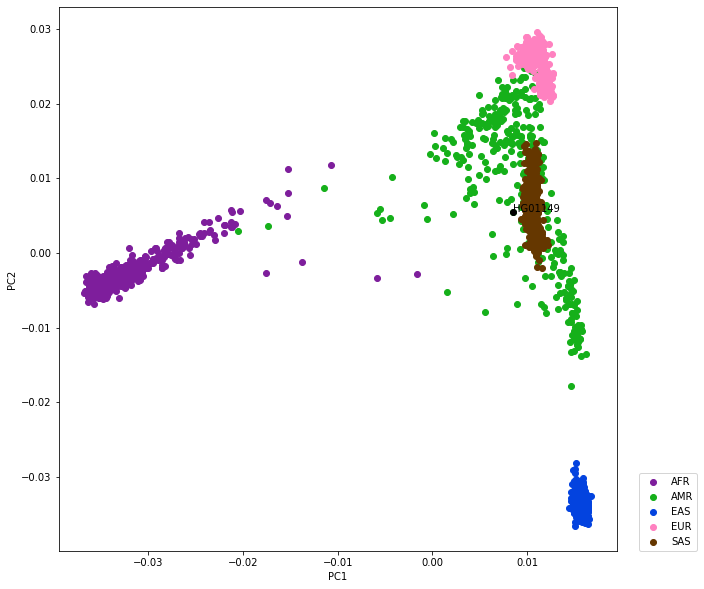

In [21]:
# Plot the top two PCs. Population labels = super_population
plot_pcs(pcs, 1, 2, pcs.super_population, [my_individual])

26


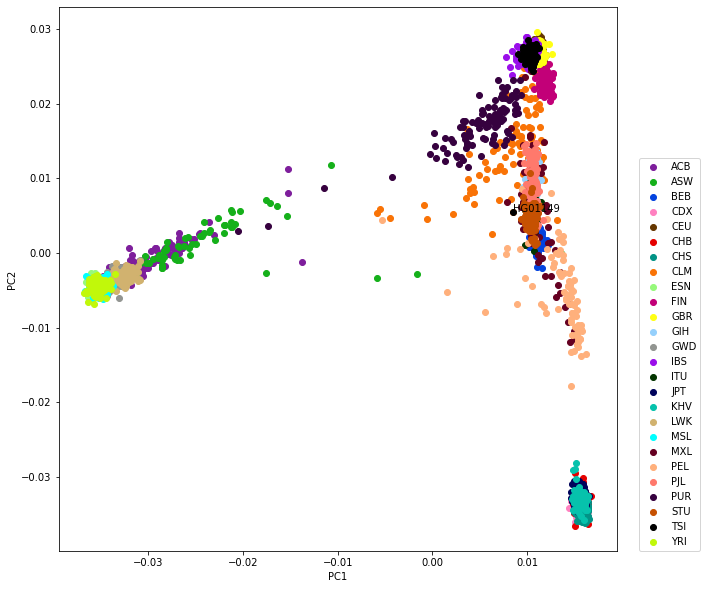

In [22]:
# Plot the top two PCs. Population labels = population
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

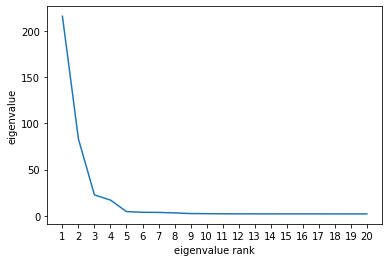

In [23]:
eigenvalues = np.loadtxt('1000G.eval')
plt.plot(np.arange(1, 21), eigenvalues[:20])
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('eigenvalue');

%Variance explained

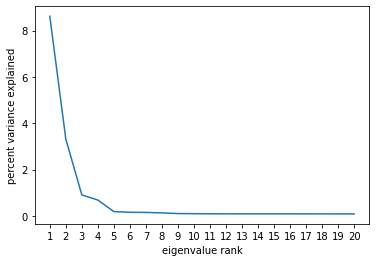

In [24]:
eigenvalues = np.loadtxt('1000G.eval')
plt.plot(np.arange(1, 21), 100 * eigenvalues[:20] / eigenvalues.sum())
plt.xticks(np.arange(1, 21));
plt.xlabel('eigenvalue rank')
plt.ylabel('percent variance explained');

## Exercise: explore your continental group

Write population list

In [ ]:
np.savetxt('pop.list', individuals[individuals.super_population==my_continental_group].population.unique().astype(str), fmt='%s')

In [ ]:
%%writefile 1000G.continent.smartpca.par
genotypename: 1000G.geno     # file with genotype information
snpname:      1000G.snp      # file with snp information
indivname:    1000G.ind      # file with individual information   
poplistname:  pop.list # list of pops to include in the run.
evecoutname:  1000G.continent.evec     # output file of eigenvectors.
evaloutname:  1000G.continent.eval     # output file of all eigenvalues
snpweightoutname: 1000G.continent.Weightout.txt
phylipname:   1000G.continent.phyl     # file with Fst values across populations 
numoutevec:   10               # number of PCs to output 
numthreads:   1                # if running interactively, use 1 only
outliermode: 2
#outliermode should be 0, 1 or 2 
#mode = 2  NO outlier removal 
#mode = 1  when calculating mean and standard deviation of a PC to decide whether to remove a sample the 
# sample itself is not used.   This may be important for datasets with very small sample sizes (say less than 30).  
#mode = 0  (default) use all samples to compute PC mean and variance. 

Overwriting 1000G.continent.smartpca.par


**Run smartpca**

In [ ]:
!../../bin/smartpca -p 1000G.continent.smartpca.par

parameter file: 1000G.continent.smartpca.par
### THE INPUT PARAMETERS
##PARAMETER NAME: VALUE
genotypename: 1000G_archaic.geno     
snpname: 1000G.snp      
indivname: 1000G.ind      
poplistname: pop.list 
evecoutname: 1000G.continent.evec     
evaloutname: 1000G.continent.eval     
snpweightoutname: 1000G.continent.Weightout.txt
phylipname: 1000G.continent.phyl     
numoutevec: 10               
numthreads: 1                
outliermode: 2
## smartpca version: 16000
norm used

number of samples used: 347 number of snps used: 19998
Using 1 thread, and partial sum lookup algorithm.
 snp          rs141842752 ignored . allelecnt:     0  missing:     0
 snp          rs144087919 ignored . allelecnt:     0  missing:     0
 snp           rs80151220 ignored . allelecnt:     0  missing:     0
 snp          rs182969387 ignored . allelecnt:     0  missing:     0
 snp          rs115254676 ignored . allelecnt:     0  missing:     0
 snp          rs138747494 ignored . allelecnt:     0  missing:    

In [ ]:
# Display output
n_pcs = 10
pcs = pd.read_csv('1000G.continent.evec', skiprows=1, header=None, delim_whitespace=True,
                       names=['Sample']+['PC'+str(i+1) for i in range(n_pcs)]+['population'])
pcs = pcs.merge(population_info, on='population', how='left').fillna('Archaic')
pcs = pcs[pcs.super_population==my_continental_group]
pcs.head()

,Sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,population,description,super_population
227,HG00551,-0.0492,-0.0260,-0.0063,-0.0024,0.0068,-0.0162,-0.0015,0.0427,0.0180,-0.0179,PUR,Puerto Ricans from Puerto Rico,AMR
228,HG00553,-0.0416,0.0411,-0.0062,-0.0257,0.0223,-0.0026,0.0342,0.0354,0.0769,-0.0034,PUR,Puerto Ricans from Puerto Rico,AMR
229,HG00554,-0.0490,-0.0211,0.0055,-0.0029,0.0260,0.0234,0.0073,0.0302,0.0051,0.0025,PUR,Puerto Ricans from Puerto Rico,AMR
265,HG00637,-0.0579,0.0025,0.0086,-0.0127,0.0243,0.0368,0.0245,0.0059,0.0417,0.0118,PUR,Puerto Ricans from Puerto Rico,AMR
266,HG00638,-0.0539,0.0175,0.0001,-0.0223,0.0593,0.0256,0.0787,-0.0052,0.0525,0.0636,PUR,Puerto Ricans from Puerto Rico,AMR


4


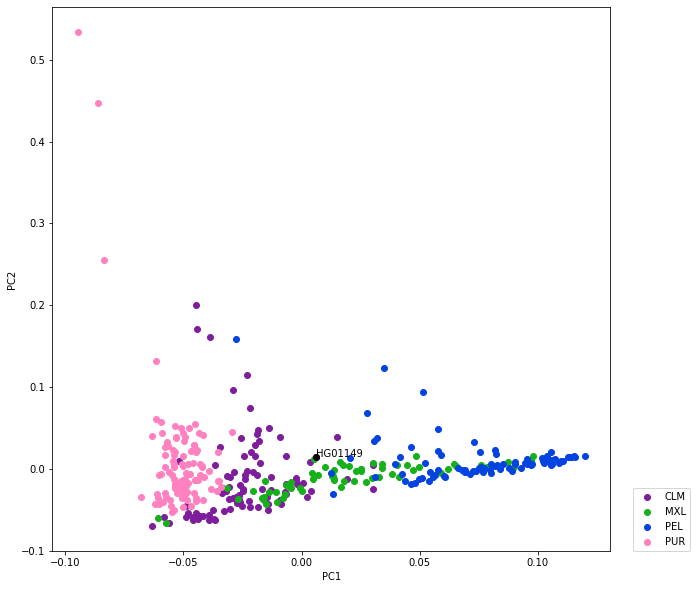

In [ ]:
# plot PCA output
plot_pcs(pcs, 1, 2, pcs.population, [my_individual])

### Stop! Check your understanding
1. Find your individual in our individuals dataframe; what is their sex, population, and superpopulation?


The smartpca program also outputs useful statistics after each run. One of these files, [name].phyl, has information about Fst values between all populations within your superpopulation.<br>
<br>
&emsp;&emsp;<ins>Fst</ins>: a measure of genetic differentiation between two populations, based on within-population structure.
2. Find the value of Fst between your population and every other one in the superpopulation.

# Admixture analysis

Alexander, David H., John Novembre, and Kenneth Lange. "Fast model-based estimation of ancestry in unrelated individuals." Genome research 19.9 (2009): 1655-1664.

https://genome.cshlp.org/content/19/9/1655.full

Software documentation: http://www.genetics.ucla.edu/software/admixture/admixture-manual.pdf

Usage: 

```!../../bin/admixture --cv 1000G.bed K```

where K = number of clusters

Running ADMIXTURE with K=2 clusters

In [25]:
!../../bin/admixture --cv 1000G.bed 2

****                   ADMIXTURE Version 1.21                   *****
****                    Copyright 2008-2011                     *****
****          David Alexander, John  Novembre, Ken Lange        *****
****                   Please cite our paper!                   *****
****   Information at www.genetics.ucla.edu/software/admixture  *****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 2506x19998
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 2.205	Loglikelihood: -4.47361e+07	(delta): 4.13289e+07
^C


Each line in the output of ADMIXTURE contains the probability of an individual belonging to each cluster - not be to confused with ancestry proportion.

In [ ]:
admix = pd.read_csv('1000G.2.Q', ' ', header=None).values[order]
admix

array([[0.174494, 0.825506],
       [0.441195, 0.558805],
       [0.042493, 0.957507],
       ...,
       [0.841677, 0.158323],
       [0.114301, 0.885699],
       [0.195767, 0.804233]])

Admixture plot where each color represents one cluster


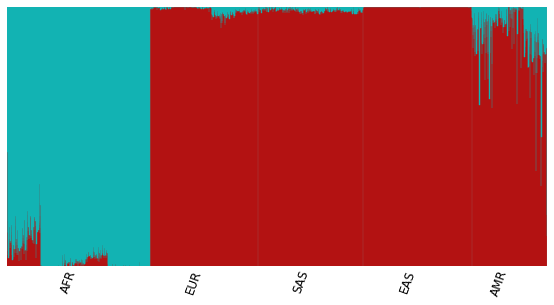

In [ ]:
plot_admixture(admix, individuals.super_population.cat.codes, individuals.super_population.cat.categories);

Admixture plot with subcontinental ancestry where each color represents one cluster


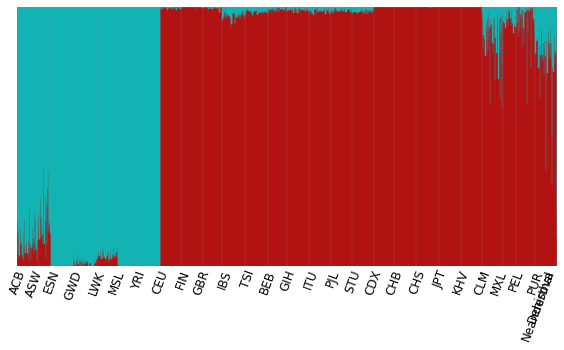

In [ ]:
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

Admixture output for the current individual


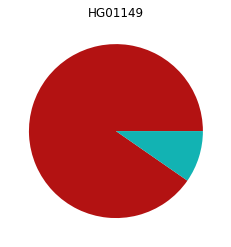

In [ ]:
plot_admix_individual(admix, my_individual)

**Now let's run admixture with K=3 clusters**

In [ ]:
!../../bin/admixture --cv 1000G.bed 3

****                   ADMIXTURE Version 1.21                   *****
****                    Copyright 2008-2011                     *****
****          David Alexander, John  Novembre, Ken Lange        *****
****                   Please cite our paper!                   *****
****   Information at www.genetics.ucla.edu/software/admixture  *****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 2506x19998
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 3.028	Loglikelihood: -4.51512e+07	(delta): 3.55314e+07
2 (EM) 	Elapsed: 3.027	Loglikelihood: -4.38197e+07	(delta): 1.33149e+06
3 (EM) 	Elapsed: 3.022	Loglikelihood: -4.34422e+07	(delta): 377505
4 (EM) 	Elapsed: 3.018	Loglikelihood: 

Output of ADMIXTURE (K=3)

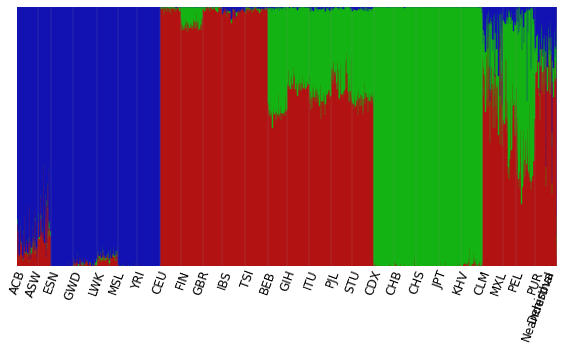

In [ ]:
admix = pd.read_csv('1000G.3.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

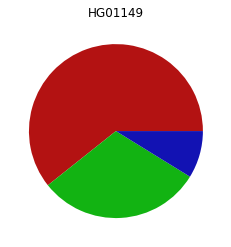

In [ ]:
plot_admix_individual(admix, my_individual)

For K=4,5,6 results have been precomputed, we can just load them. <br><br>Output of ADMIXTURE (K=4)


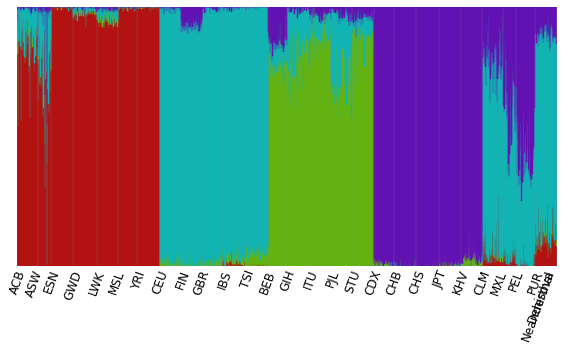

In [ ]:
admix = pd.read_csv('1000G.4.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

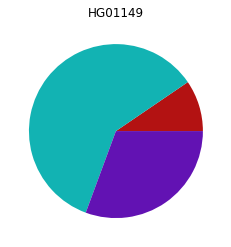

In [ ]:
# Admixture output for the current individual (K=4)
plot_admix_individual(admix, my_individual)

Output of ADMIXTURE (K=5)


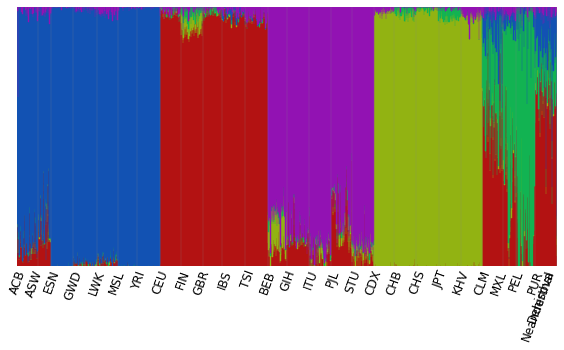

In [ ]:
admix = pd.read_csv('1000G.5.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

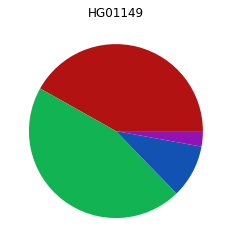

In [ ]:
plot_admix_individual(admix, my_individual)

Output of ADMIXTURE (K=6)


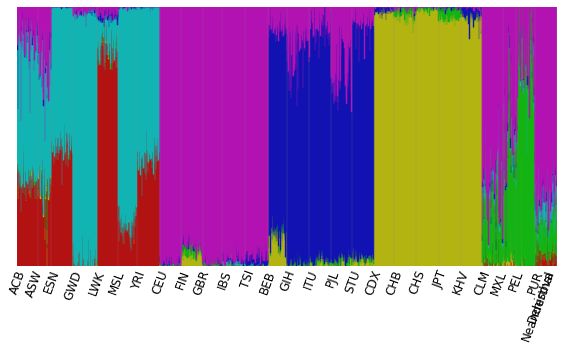

In [ ]:
admix = pd.read_csv('1000G.6.Q', ' ', header=None).values[order]
plot_admixture(admix, individuals.population.cat.codes, individuals.population.cat.categories);

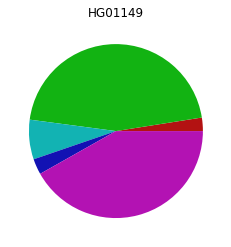

In [ ]:
plot_admix_individual(admix, my_individual)

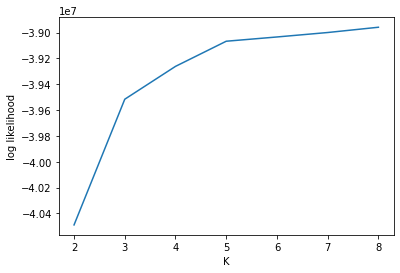

In [ ]:
# Likelihood of data as a function of K, the number of clusters
K = np.arange(2, 9)
log_likelihood = [-40488756, -39516004, -39261878, -39067307, -39034320, -38999856, -38959044]
#still am not seeing where these numbers come from? Not in any files in data dir
plt.plot(K, log_likelihood)
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('log likelihood');